In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
train = pd.read_csv("train.csv", low_memory=False)
store = pd.read_csv("store.csv")

print(train.shape)
print(store.shape)

(1017209, 9)
(1115, 10)


In [3]:
df = pd.merge(train, store, on="Store", how="left")
print(df.head())
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Remove closed store sales
df = df[df['Open'] == 1]

# Fill missing values
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df.fillna(0, inplace=True)

print(df.isnull().sum())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                   

C:\Users\shiva\AppData\Local\Temp\ipykernel_22864\2233652167.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


In [4]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Holiday flag
df['IsPromo'] = df['Promo'].astype(int)


In [5]:
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

print(daily_sales.head())


          ds        y
0 2013-01-01    97235
1 2013-01-02  6949829
2 2013-01-03  6347820
3 2013-01-04  6638954
4 2013-01-05  5951593


In [6]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(daily_sales)


15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing


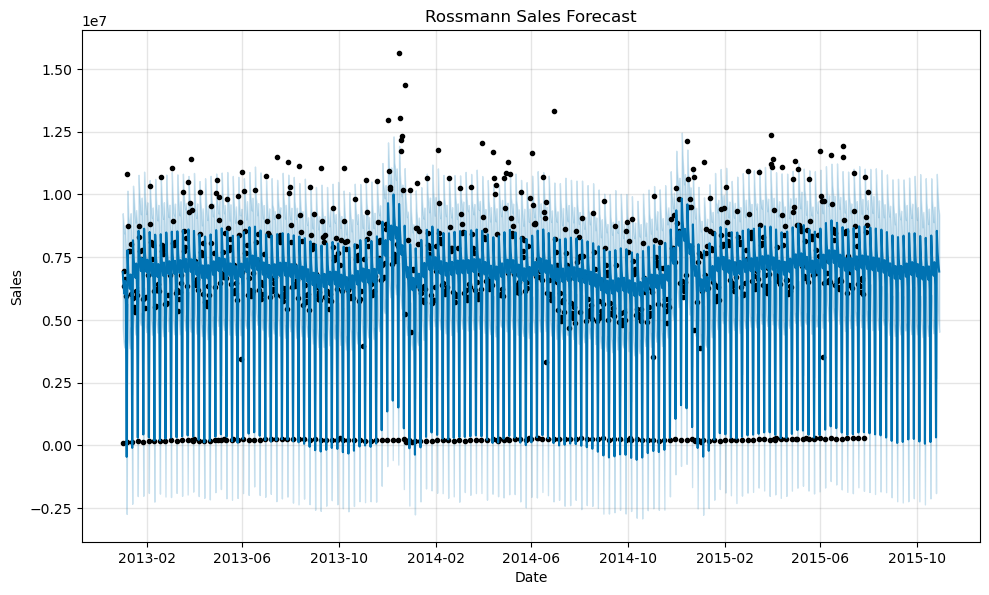

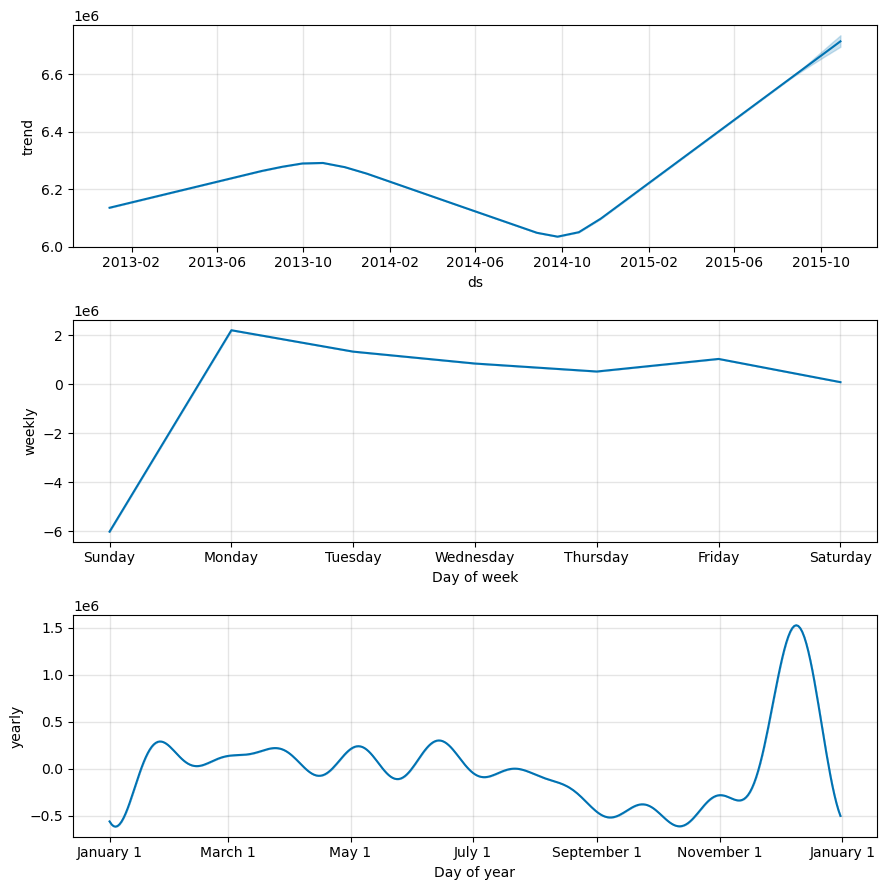

In [7]:
future = model.make_future_dataframe(periods=90) 
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#plotting
model.plot(forecast)
plt.title("Rossmann Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()
#trend_seasonalcomponents
model.plot_components(forecast)
plt.show()


In [8]:
#Data for Power BI
powerbi_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
powerbi_data.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Sales',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
}, inplace=True)

powerbi_data.to_csv("rossmann_sales_forecast.csv", index=False)


C:\Users\shiva\AppData\Local\Temp\ipykernel_22864\2019615209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powerbi_data.rename(columns={


In [9]:
actual_sales = daily_sales.copy()
actual_sales.columns = ['Date', 'Actual_Sales']
actual_sales.to_csv("rossmann_actual_sales.csv", index=False)
